# Notebook de Modélisation 

In [6]:
import os
import re
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud

tqdm.pandas()

import string
import warnings

warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer

## Extraction des donnees 

In [7]:
# Extraction des données
ZIP_PATH = '../data/sentiment140.zip'
DATA_PATH = '../data'

# Verifier l'existance des data et extraire le zip dedans
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_PATH)
    print("Fichiers extraits avec succès dans :", DATA_PATH)
else:
    print('Folder existant !')

print(f'Liste des dossier et fichier disponible {os.listdir(DATA_PATH)}')

Fichiers extraits avec succès dans : ../data
Liste des dossier et fichier disponible ['sentiment140.zip', 'training.1600000.processed.noemoticon.csv']


## Lecture du dataframe

In [8]:
DATASET_PATH = os.path.join(DATA_PATH, 'training.1600000.processed.noemoticon.csv')
df = pd.read_csv(DATASET_PATH, sep=',', encoding = "ISO-8859-1", header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Preprocessing

### Renommer les colonnes

[Data card des colonnes](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [35]:
df = df.rename(columns={
    df.columns[0]: 'target', 
    df.columns[1]: 'ids', 
    df.columns[2]: 'date',
    df.columns[3]: 'flag',
    df.columns[4]: 'user',
    df.columns[5]: 'text',
    })

useful_df = df[['target', 'text']].sample(150_000)

### Target

In [36]:
print(useful_df['target'].value_counts())

# Conversion en binaire 0,1
useful_df['target'] = useful_df['target'].replace({0: 0, 4: 1})

print(useful_df['target'].value_counts())

target
4    75035
0    74965
Name: count, dtype: int64
target
1    75035
0    74965
Name: count, dtype: int64


### Text preprocessing

In [37]:

def tweet_cleaning(tweet):
    """
    Nettoie et prétraite un tweet pour une analyse de sentiment.
    
    Cette fonction effectue plusieurs étapes de nettoyage :
        - Suppression des URLs, mentions et hashtags
        - Suppression des emojis et caractères spéciaux
        - Suppression de la ponctuation et des chiffres
        - Normalisation du texte (minuscules, espaces multiples)
    
    Params :
        tweet (str) : Le tweet brut à nettoyer.
    
    Return :
        str : Le tweet nettoyé et prétraité, prêt pour l'analyse de sentiment.
    
    """
    # Supprimer les URLs
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)
    
    # Supprimer les mentions (@user)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Supprimer les hashtags (#hashtag)
    tweet = re.sub(r'#\w+', '', tweet)
    
    # Normaliser & supprimer les caractères Unicode problématiques
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    
    # Supprimer la ponctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Supprimer les chiffres
    tweet = re.sub(r'\d+', '', tweet)
    
    # Supprimer les espaces multiples et les espaces au début/fin
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    return tweet
    
    

In [38]:
useful_df['text'] = useful_df['text'].progress_apply(tweet_cleaning)

100%|██████████| 150000/150000 [00:01<00:00, 95197.37it/s] 


In [39]:
useful_df.text.sample()

359924    I wish except I dont know if Ill be here
Name: text, dtype: object

## Visualisation

### Nuage de mots

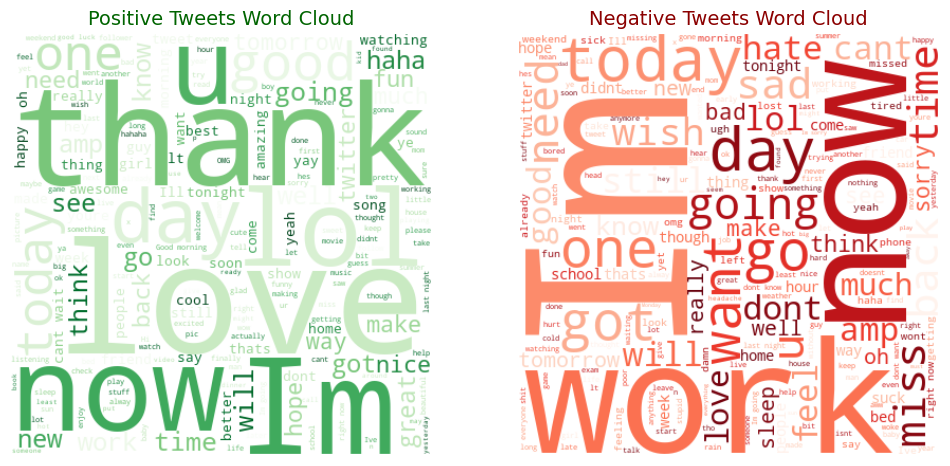

In [40]:
# TF-IDF for text
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(useful_df["text"]).toarray()
useful_df["text_features"] = X_text.mean(axis=1)


positive_text = " ".join(useful_df[useful_df["target"] == 1]["text"])
negative_text = " ".join(useful_df[useful_df["target"] == 0]["text"])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=400, height=400, background_color="white", colormap="Greens").generate(positive_text)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Tweets Word Cloud", fontsize=14, color="darkgreen")

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=400, height=400, background_color="white", colormap="Reds").generate(negative_text)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Tweets Word Cloud", fontsize=14, color="darkred")
plt.show()

# Modèle sur mesure simple

In [41]:
# Define data to train
x=useful_df["text"]
y=useful_df["target"]

In [42]:
def compare_vectorizer(X, y):
    # Division des données
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def evaluate_model(vectorizer, model_name, is_sentence_transformer=False):
        if is_sentence_transformer:
            # Cas des modèles SentenceTransformer
            X_train_vec = vectorizer.encode(x_train, show_progress_bar=False)
            X_test_vec = vectorizer.encode(x_test, show_progress_bar=False)
        else:
            # Cas de TF-IDF et CountVectorizer
            X_train_vec = vectorizer.fit_transform(x_train)
            X_test_vec = vectorizer.transform(x_test)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_vec, y_train)

        y_pred = model.predict(X_test_vec)

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        metrics = {
            'accuracy': acc,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1-score': report['weighted avg']['f1-score']
        }

        return {model_name: metrics}

    # Évaluation des trois vectorizers
    tfidf_metrics = evaluate_model(TfidfVectorizer(), 'TF-IDF')
    count_metrics = evaluate_model(CountVectorizer(), 'Count')
    sbert_model = SentenceTransformer('../models/sentence_transformers')
    sbert_metrics = evaluate_model(sbert_model, 'Sentence-BERT', is_sentence_transformer=True)

    all_metrics = {}
    all_metrics.update(tfidf_metrics)
    all_metrics.update(count_metrics)
    all_metrics.update(sbert_metrics)

    # Préparation des données pour le plot
    metrics_names = ['accuracy', 'precision', 'recall', 'f1-score']
    x_indexes = np.arange(len(metrics_names))
    bar_width = 0.25  # Réduit pour ajouter une 3e barre

    tfidf_values = [all_metrics['TF-IDF'][m] for m in metrics_names]
    count_values = [all_metrics['Count'][m] for m in metrics_names]
    sbert_values = [all_metrics['Sentence-transformers'][m] for m in metrics_names]

    # Création du graphique
    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(x_indexes - bar_width, tfidf_values, width=bar_width, label='TF-IDF Vectorizer', color='#4E79A7')
    bars2 = plt.bar(x_indexes, count_values, width=bar_width, label='Count Vectorizer', color='#F28E2B')
    bars3 = plt.bar(x_indexes + bar_width, sbert_values, width=bar_width, label='Sentence-BERT', color='#76448A')

    # Ajout des valeurs au-dessus des barres
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center', va='bottom', fontsize=9)

    plt.xticks(x_indexes, metrics_names)
    plt.ylabel("Score")
    plt.title("Comparaison des performances des vectorizers")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
compare_vectorizer(x.to_list(), y.to_list())

In [ ]:
import numpy as np


def plot_top_features(model, vectorizer, n=10):
    # Récupérer les coefficients du modèle
    coefs = model.coef_[0]
    feature_names = vectorizer.get_feature_names_out()

    # Associer les poids aux mots
    top_positive = np.argsort(coefs)[-n:][::-1]  # Mots liés à la classe positive (target=1)
    top_negative = np.argsort(coefs)[:n]         # Mots liés à la classe négative (target=0)

    # Créer un DataFrame pour afficher
    import pandas as pd
    df = pd.DataFrame({
        'Positive Class (1)': np.take(feature_names, top_positive),
        'Negative Class (0)': np.take(feature_names, top_negative)
    })

    print("\nTop mots caractéristiques par classe :")
    print(df)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))

    y_pos = np.arange(n)
    ax.barh(y_pos, coefs[top_positive], align='center', color='green', label='Positif')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(np.take(feature_names, top_positive))
    ax.invert_yaxis()
    ax.set_xlabel('Importance (poids du modèle)')
    ax.set_title('Mots les plus influents pour la classe Positive (1)')
    plt.tight_layout()
    plt.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 5))

    y_pos = np.arange(n)
    ax.barh(y_pos, coefs[top_negative], align='center', color='red', label='Négatif')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(np.take(feature_names, top_negative))
    ax.invert_yaxis()
    ax.set_xlabel('Importance (poids du modèle)')
    ax.set_title('Mots les plus influents pour la classe Négative (0)')
    plt.tight_layout()
    plt.legend()
    plt.show()

# Appel de la fonction
# plot_top_features(model, vectorizer, n=20)

# Modèle sur mesure avancé

- 2 word embedding
- Regarder l'apport en perf d'un modèle bert

# 